# Random Forest

## Library Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

import glob
import os
import seaborn as sns
import warnings

In [2]:
warnings.filterwarnings('ignore')

## Data Import

In [3]:
! ls ./Bot_Iot_Data_File/Entire_Dataset/UNSW_2018_IoT_Botnet_Final_10_Best.csv

./Bot_Iot_Data_File/Entire_Dataset/UNSW_2018_IoT_Botnet_Final_10_Best.csv


In [4]:
data = pd.read_csv('./Bot_Iot_Data_File/Entire_Dataset/UNSW_2018_IoT_Botnet_Final_10_Best.csv', sep = ';', index_col=0)
data

,pkSeqID,proto,saddr,sport,daddr,dport,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack,category,subcategory
0,1,tcp,192.168.100.147,49960,192.168.100.7,80,9,0.068909,75,0.000000,1,0.068909,96,14.511893,0.566862,0.137818,1,DoS,HTTP
1,2,arp,192.168.100.7,-1,192.168.100.147,-1,10,0.000000,2,0.000131,2,0.000131,1,0.000000,0.000000,0.000131,1,DoS,HTTP
2,3,tcp,192.168.100.147,49962,192.168.100.7,80,11,0.064494,75,0.000000,1,0.064494,96,15.505319,0.567549,0.128988,1,DoS,HTTP
3,4,tcp,192.168.100.147,49964,192.168.100.7,80,12,0.064189,75,0.000000,1,0.064189,96,15.578993,0.567570,0.128378,1,DoS,HTTP
4,5,tcp,192.168.100.147,49966,192.168.100.7,80,13,0.063887,75,0.000000,1,0.063887,96,15.652637,0.567630,0.127774,1,DoS,HTTP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3668517,3668518,tcp,192.168.100.150,35064,192.168.100.3,22,81,0.000000,19,0.013165,1,0.013165,19,151.917969,151.917969,0.013165,1,Theft,Keylogging
3668518,3668519,tcp,192.168.100.150,35066,192.168.100.3,22,82,0.000000,19,0.000574,1,0.000574,19,3484.320557,3484.320557,0.000574,1,Theft,Keylogging
3668519,3668520,tcp,192.168.100.150,35070,192.168.100.3,22,84,0.000000,19,2.874302,6,2.874302,19,5.566569,4.522837,2.874302,1,Theft,Keylogging
3668520,3668521,tcp,192.168.100.3,43001,192.168.100.150,4433,85,0.000000,3,0.000003,1,0.000003,1,0.000000,0.000000,0.000003,1,Theft,Keylogging


In [5]:
data.category.unique()

array(['DoS', 'DDoS', 'Normal', 'Reconnaissance', 'Theft'], dtype=object)

## Feature와 Target 설정
Feature는 joint함수를 활용하여 설정

In [6]:
best_cols = ['seq', 'stddev', 'N_IN_Conn_P_SrcIP', 'min', 'state_number', 'mean', 'N_IN_Conn_P_DstIP', 'drate', 'srate', 'max']
target_col = ['category']

In [7]:
data = data[best_cols + target_col]

In [8]:
data.head(5)

,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,category
0,9,0.068909,75,0.000000,1,0.068909,96,14.511893,0.566862,0.137818,DoS
1,10,0.000000,2,0.000131,2,0.000131,1,0.000000,0.000000,0.000131,DoS
2,11,0.064494,75,0.000000,1,0.064494,96,15.505319,0.567549,0.128988,DoS
3,12,0.064189,75,0.000000,1,0.064189,96,15.578993,0.567570,0.128378,DoS
4,13,0.063887,75,0.000000,1,0.063887,96,15.652637,0.567630,0.127774,DoS


In [9]:
X_orig = data.drop(columns = target_col)
y = data[target_col]
y = np.ravel(y)
y

array(['DoS', 'DoS', 'DoS', ..., 'Theft', 'Theft', 'Theft'], dtype=object)

## 데이터 전처리 및 정규화

### Target이 범주형 데이터이므로 LabelEncoder사용

In [10]:
le = LabelEncoder()
y = le.fit_transform(y)

### Feature들은 수치형 데이터이므로 StandardScaler 사용

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_orig)
X_scaled = scaler.transform(X_orig)
X = pd.DataFrame(X_scaled, columns=best_cols)

### Train & Test 분리

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Random Forest 학습

In [13]:
rf = RandomForestClassifier(n_estimators=20, max_depth=5,random_state=42)
rf.fit(X_train,y_train)
predict1 = rf.predict(X_test)
print(accuracy_score(y_test,predict1))

0.9737887269809742


[[566246  11722      0      6      0]
 [ 16101 479143      0      8      0]
 [     2     27      0    112      0]
 [   809     36      0  26321      0]
 [     0      1      0     23      0]]


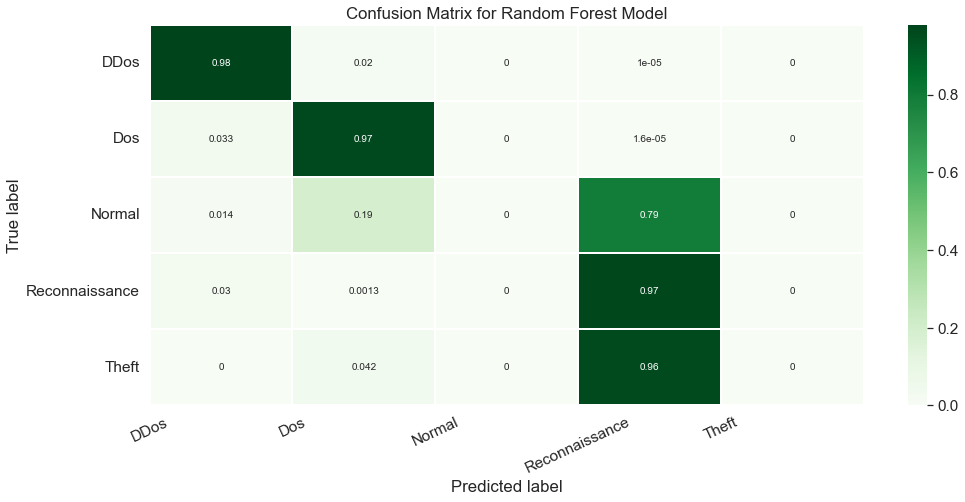

DDoS              1926624
DoS               1650260
Reconnaissance      91082
Normal                477
Theft                  79
Name: category, dtype: int64

In [14]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, predict1)
print(matrix)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['DDos', 'Dos', 'Normal', 'Reconnaissance', 
               'Theft']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()
data.category.value_counts()

In [15]:
dic = {'zero':0, 'one':0, 'two':0, 'three':0, 'four':0}
for i in predict1:
    if i == 0:
        dic['zero'] += 1
    elif i == 1:
        dic['one'] += 1
    elif i == 2:
        dic['two'] += 1
    elif i == 3:
        dic['three'] += 1
    elif i == 4:
        dic['four'] += 1
dic

{'zero': 583158, 'one': 490929, 'two': 0, 'three': 26470, 'four': 0}

## Feature의 중요도 

In [16]:
rf.feature_importances_

array([0.02119182, 0.08454439, 0.04199309, 0.06788899, 0.15510891,
       0.06357739, 0.24300814, 0.00379988, 0.2473538 , 0.07153358])

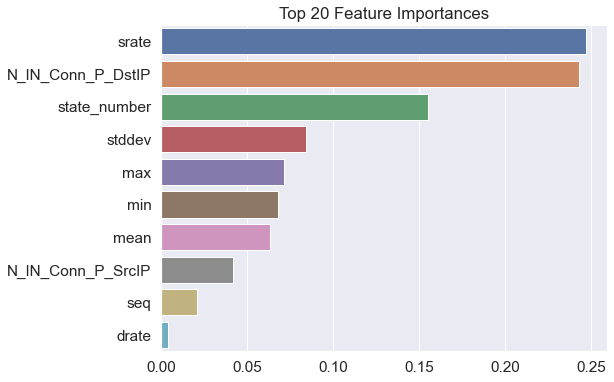

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Top 20 Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

### GridSearchCV를 통한 최적의 파라미터 계산

In [ ]:
params = { 'n_estimators' : list(range(0, 50, 10)),
           'max_depth' : list(range(0, 20, 5)),
            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

### RandomizedSearchCV를 통한 최적의 파라미터 계산

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
max_features = ['sqrt', 'log2']
max_depth = [2,4, 6, 8]
min_samples_split = [2, 5]
min_samples_leaf = [1, 2]
bootstrap = [True, False]

In [ ]:
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
rf_Model = RandomForestClassifier()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
rf_RandomGrid = RandomizedSearchCV(estimator = rf_Model, param_distributions = param_grid, cv = 10, verbose=2, n_jobs = 4)

In [ ]:
rf_RandomGrid.fit(X_train, y_train)

In [ ]:
param_score = pd.DataFrame(rf_RandomGrid.cv_results_).sort_values('rank_test_score')
param_score[param_score.rank_test_score == 1]